## Lab9 Take home

Name: RM Pramod Wickramatilake
ID: st121295



First lets use pytorch on the MNIST dataset and see if everything works as expected, next we will use pytorch on the breast cancer dataset


## MNIST digit recognition using PyTorch

This part of the lab was
taken from the [Kaggle tutorial on MNIST with PyTorch]('https://www.kaggle.com/justuser/mnist-with-pytorch-fully-connected-network).

We will use a fully connected neural network and a batch learning algorithm and explain each
step along the way.

So, with that being said, let's start with imports that we will need.
First of all, we need to import PyTorch. There are some common names for torch modules (like numpy is always named np):  torch.nn.functional is imported as F,  torch.nn is the core module, and is simply imported as nn.
Also, we need numpy. We also use pyplot and seaborn for visualization, but they are not required for the network itself. 
And finally, we use pandas for importing and transforming data.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Now we can import and transform the data. I decided to split it into input and labels right away at this step:

In [2]:
print("Reading the data...")
data = pd.read_csv('train_mnist.csv', sep=",")
test_data = pd.read_csv('test_mnist.csv', sep=",")

print("Reshaping the data...")
dataFinal = data.drop('label', axis=1)
labels = data['label']


dataNp = dataFinal.to_numpy()
labelsNp = labels.to_numpy()
test_dataNp = test_data.to_numpy()

print("Data is ready")

Reading the data...
Reshaping the data...
Data is ready


Now that data is ready, we can take a look at what we're dealing with. I will be using heatmaps from seaborn, which is an excellent tool for matrix visualization. But first, since the images in the MNIST dataset are represented as a long 1d arrays of pixels, we will need to reshape it into 2d array. That's where .reshape() from numpy comes in handy. The pictures are 28 x 28 pixels, so these will be the parameters.

Let's select a couple random samples and visualize them. I will also print their labels, so we can compare images with their actual value:

8  /  9
8  /  4
9  /  1


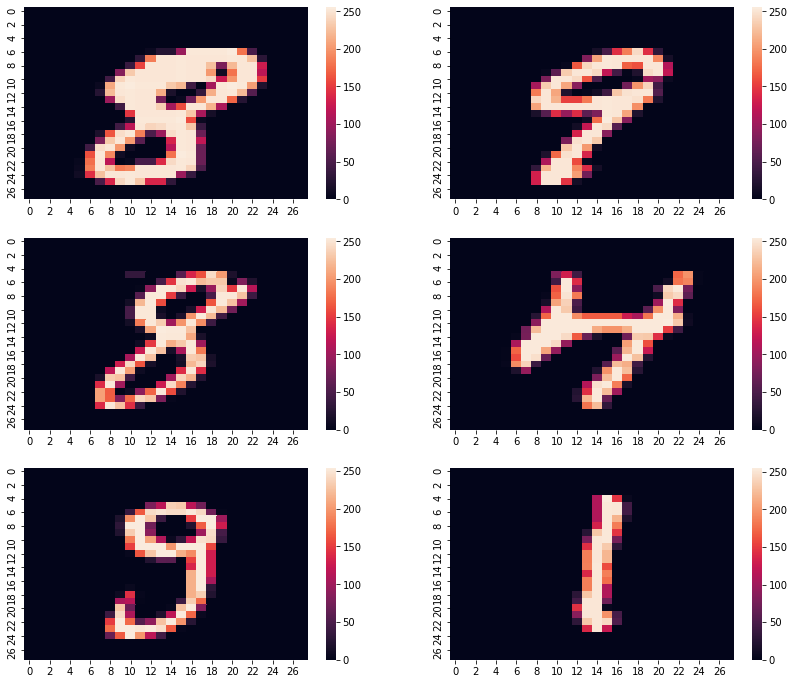

In [3]:
plt.figure(figsize=(14, 12))

pixels = dataNp[10].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)

pixels = dataNp[11].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)

pixels = dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)

pixels = dataNp[32].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)

pixels = dataNp[40].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)

pixels = dataNp[52].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)

print(labels[10], " / ", labels[11])
print(labels[20], " / ", labels[32])
print(labels[40], " / ", labels[52])

PyTorch has it's own way to store data - those are called tensors, and they are just like numpy arrays, but are suited for PyTorch needs. If we want to feed the data to the network, we need to transform the dataset into those tensors. The good news is that PyTorch can easily do that by transforming numpy arrays or regular lists into tensors.

In [4]:
x = torch.FloatTensor(dataNp.tolist())
y = torch.LongTensor(labelsNp.tolist())

Before we start writing the actual network, we need to determine what will be the hyperparameters. Those will not be adjusted during training, so we need to be careful how we set them up. 

Here's what we will specify:
* **input_size** - size of the input layer, it is always fixed (784 pixels)
* **output_size** - size of the output layer, also fixed size (10 for every possible digit)
* **hidden_size** - size of the hidden layer, this parameter determines structure of the network. 200 worked for me, but it is worth to play with this parameter to see what works for you
* **epochs** - how many times will the network go through the entire dataset during training. 
* **learning_rate** - determines how fast will the network learn. You should be very careful about this parameter, because if it is too high, the network won't learn at all, if it is too low, the net will learn too long. I's always about balance. Usualy 10^-3 - 10^-5 works just fine.
* **batch_size** - size of mini batches during training

In [5]:
# hyperparameters
input_size = 784
output_size = 10
hidden_size = 200

epochs = 20
batch_size = 50
learning_rate = 0.00005

Now we can finally write the actual network. To make it all work, the Network class needs to inherit the *nn.Module*, which gives it the basic functionality required, and allows PyTorch to work with it as expected. 

When writing a PyTorch neural network, some things must always be there:
* \__init\__(self) - initializes the net and creates an instance of that *nn.Module*. Here we define the structure of the network.
* forward(self, x) - defines forward propagation and how the data flow through the network. Of course, it is based on the structure that is defined in the previous function.

In the initialization, first of all, we need to initialize super (or base) module that the net inherits. After that first line, is the definition of structure. You can experiment with (put more layers or change hidden layer size, etc.), but this structure worked for me just fine.

In forward propagation we simply reassign the value of x as it flows through the layers and return the [softmax](https://en.wikipedia.org/wiki/Softmax_function) at the end.

In [6]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

After we've defined the network, we can initialize it. 
Also, if we "print" the instance of the net, we can see the structure of it in a neat format:

In [7]:
net = Network()
print(net)

Network(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)


Now it's time to set up the [optimizer](http://pytorch.org/docs/master/optim.html) and a loss function. 

*There are quite a lot of things happening behind these two lines of code, so if you don't know what is going on here, don't worry too much for now, it will get clearer eventualy.* 

Optimizer is what  updates the parameters of the network. I will be using Stochastic Gradient Descent with momentum. Also, the optimizer takes the network parameters as an argument, but it's not a big deal since we can get those with .parameters() function.

I decided to use [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy) for this problem, but again, there are many options and you are free to choose whatever suits you best.

In [8]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

Now that everything is ready, our network can start learning. I will separate data into minibatches and feed it to the network. It has many advantages over single batch learning, but that is a different story. 

Also, I will use loss_log list to keep track of the loss function during the training process. 

In [9]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
        
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e, loss.item()))

Epoch: 0 - Loss: 0.036627
Epoch: 1 - Loss: 0.018152
Epoch: 2 - Loss: 0.015094
Epoch: 3 - Loss: 0.014763
Epoch: 4 - Loss: 0.016684
Epoch: 5 - Loss: 0.017684
Epoch: 6 - Loss: 0.019545
Epoch: 7 - Loss: 0.018160
Epoch: 8 - Loss: 0.016001
Epoch: 9 - Loss: 0.018139
Epoch: 10 - Loss: 0.016882
Epoch: 11 - Loss: 0.015907
Epoch: 12 - Loss: 0.015027
Epoch: 13 - Loss: 0.013100
Epoch: 14 - Loss: 0.012840
Epoch: 15 - Loss: 0.012876
Epoch: 16 - Loss: 0.011333
Epoch: 17 - Loss: 0.009890
Epoch: 18 - Loss: 0.009444
Epoch: 19 - Loss: 0.008115


So, let's go line by line and see what is happening here:

This is the main loop that goes through all the epochs of training. An epoch is one full training on the full dataset.

    for e in range(epochs):
This is the inner loop that simply goes through the dataset batch by batch:

    for i in range(0, x.shape[0], batch_size):
Here is where we get the batches out of our data and simply assign them to variables for further work:

    x_mini = x[i:i + batch_size] 
    y_mini = y[i:i + batch_size] 
   These two lines are quite *important*. Remember I told you about tensors and how PyTorch stores data in them? That's not the end of story. Actually, to allow the network to work with data, we need a wrapper for those tensors called Variable. It has some additional properties, like allowing automatic gradient computation when backpropagating. It is required for the proper work of PyTorch, so we will add them here and supply tensors as parameters:
   
    x_var = Variable(x_mini)
    y_var = Variable(y_mini)
This line just resets the gradient of the optimizer:
    
    optimizer.zero_grad()
Remember the *forward(self, x)* function that we previously defined? The next line is basically calling this function and does the forward propagation:

    net_out = net(x_var)
This line computes the loss function based on predictions of the net and the correct answers:

    loss = loss_func(net_out, y_var)
Here we compute the gradient based on the loss that we've got. It will be used to adjust parameters of the network.

    loss.backward()
And here is where we finally update our network with new adjusted parameters:

    optimizer.step()
The rest is just logging, which might be helpful to observe how well the network is performing.

After the network is done with training, we can take a look at the loss function, and how it behaved during training:

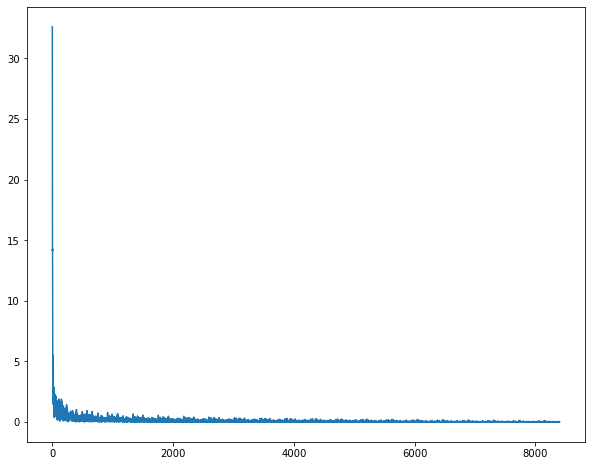

In [10]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

At this point, the network should be trained, and we can make a prediction using the test dataset. All we need to do is wrap the data into the Variable and feed it to the trained net, so nothing new here.

In [11]:
test = torch.FloatTensor(test_dataNp.tolist())
test_var = Variable(test)

net_out = net(test_var)

print(torch.max(net_out.data, 1)[1].numpy())

[2 0 9 ... 3 9 2]


Now we have out predictions that are ready to be submitted. Before that, we can take a look at predictions and compare them to the actual pictures of digits, just like at the start with training data:

Prediction: 0 / 5
Prediction: 9 / 7
Prediction: 0 / 8


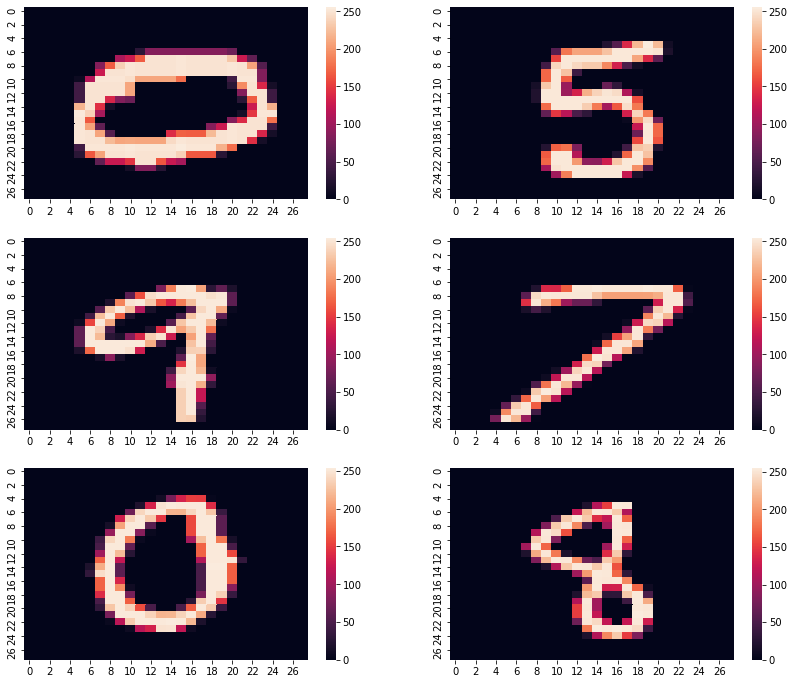

In [12]:
plt.figure(figsize=(14, 12))

pixels = test_dataNp[1].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[10].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[10].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[20].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[30].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[30].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[100].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[100].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[2000].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)


print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[1], torch.max(net_out.data, 1)[1].numpy()[10]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[20], torch.max(net_out.data, 1)[1].numpy()[30]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[100], torch.max(net_out.data, 1)[1].numpy()[2000]))

In [13]:
output = (torch.max(net_out.data, 1)[1]).numpy()
#np.savetxt("out.csv", np.dstack((np.arange(1, output.size+1),output))[0],"%d,%d",header="ImageId,Label")

And that is about it, we've made a simple neural network using PyTorch that can recognize handwritten digits. Not so bad!

When I was writing this notebook, this model scorred 96.6%, which is not perfect by any means, but it's not that bad either. 

I hope this was useful for some of you. If you are totally new to deep learning, I suggest you learn how the neural networks actually work from the inside, especially the backpropagation algorithm.

These videos explain [neural nets](https://www.youtube.com/watch?v=aircAruvnKk&t=708s) and [backpropagation](https://www.youtube.com/watch?v=Ilg3gGewQ5U) quite well.

Also I suggest you to take a look at this [online book](http://neuralnetworksanddeeplearning.com/chap1.html) (it's absolutely free, btw), where neural networks are explained in great detail, and it even has an implementation of the MNIST problem from scratch, using only numpy.

If you have any feedback, feel free to leave comments down below, and good luck with your deep learning adventures :)

## Take-home exercise

Make sure you can run the PyTorch examples of MNIST classification, then apply the PyTorch example to another
classification problem you've worked with this semester, for example the breast cancer dataset. Get familiar with
working with models in PyTorch.



## Take-home Solution

Report your experiments and results in your brief lab report.

Since the MINST dataset is working with pytorch now lets try to get the breast cancer dataset prediction working.

Lets import the dataset and split into training and test with a split ratio of 0.6

In [1]:
import numpy as np
import random
from sklearn.datasets import load_breast_cancer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


data = load_breast_cancer()
y = np.matrix(data.target).T
X = np.matrix(data.data)

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return XX

XX = normalize(X)


# Partion data into training and test datasets

m, n = XX.shape
y = y.reshape(m, 1)
idx = np.arange(0, m)
random.shuffle(idx)
percent_train = .6
m_train = int(m * percent_train)
train_idx = idx[0:m_train]
test_idx = idx[m_train:]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];




now convert the np matrix into tensors so it is accepted by pytorch and we define the learning parameters for the network

In [2]:
x = torch.FloatTensor(X_train)
y = torch.FloatTensor(y_train)

In [3]:
m, n = X_train.shape
# hyperparameters
input_size = n
output_size = 1
hidden_size1 = 6
hidden_size2 = 5


epochs = 100
batch_size = 1
learning_rate = 0.005

Lets make a simple 3 layer fully connected network with sigmoid activation after each layer

In [4]:
class Network2(nn.Module):
    
    def __init__(self):
        super(Network2, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)  
        #self.sig1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size1, hidden_size2) 
        #self.sig2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size2, output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.l1(x)
        x = self.sig(x)
        x = self.l2(x)
        x = self.sig(x)
        x = self.l3(x)
        return F.sigmoid(x)

In [5]:
net = Network2()
print(net.forward)

<bound method Network2.forward of Network2(
  (l1): Linear(in_features=30, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=5, bias=True)
  (l3): Linear(in_features=5, out_features=1, bias=True)
  (sig): Sigmoid()
)>


In [6]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.MSELoss(size_average=False)

In [7]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
        
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        
    loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e, loss.item()))

Epoch: 0 - Loss: 0.071506
Epoch: 1 - Loss: 0.016357
Epoch: 2 - Loss: 0.007136
Epoch: 3 - Loss: 0.004546
Epoch: 4 - Loss: 0.002889
Epoch: 5 - Loss: 0.002090
Epoch: 6 - Loss: 0.001659
Epoch: 7 - Loss: 0.001271
Epoch: 8 - Loss: 0.001125
Epoch: 9 - Loss: 0.000908
Epoch: 10 - Loss: 0.000656
Epoch: 11 - Loss: 0.000535
Epoch: 12 - Loss: 0.000396
Epoch: 13 - Loss: 0.000317
Epoch: 14 - Loss: 0.000278
Epoch: 15 - Loss: 0.000244
Epoch: 16 - Loss: 0.000207
Epoch: 17 - Loss: 0.000269
Epoch: 18 - Loss: 0.000128
Epoch: 19 - Loss: 0.000229
Epoch: 20 - Loss: 0.000150
Epoch: 21 - Loss: 0.000105
Epoch: 22 - Loss: 0.000095
Epoch: 23 - Loss: 0.000085
Epoch: 24 - Loss: 0.000071
Epoch: 25 - Loss: 0.000059
Epoch: 26 - Loss: 0.000051
Epoch: 27 - Loss: 0.000046
Epoch: 28 - Loss: 0.000037
Epoch: 29 - Loss: 0.000031
Epoch: 30 - Loss: 0.000028
Epoch: 31 - Loss: 0.000028
Epoch: 32 - Loss: 0.000025
Epoch: 33 - Loss: 0.000023
Epoch: 34 - Loss: 0.000021
Epoch: 35 - Loss: 0.000019
Epoch: 36 - Loss: 0.000017
Epoch: 37 -

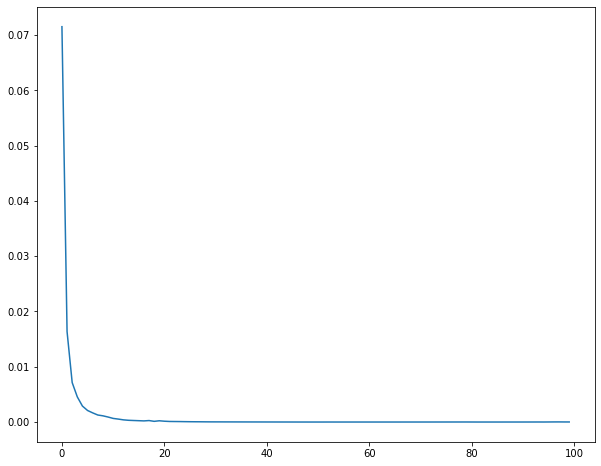

In [8]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

In [11]:
test = torch.FloatTensor(X_test)
test_var = Variable(test)

net_out = net(test_var)

#print(net_out.data)

y_out_pred=net_out.data

yy_pred=[]

for i in y_out_pred:
    if i>0.5:      
        yy_pred.append(1)
    else:
        yy_pred.append(0)


y_pred= np.matrix(yy_pred).T

y_correct = y_pred == y_test

print(np.sum(y_correct), len(y_correct))

test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))


216 228
Test accuracy: 0.9474


We obtain about 97% accuracy on the test dataset. Which is very good prediction result indeed, furthermore the model converged to this good result in less 20 epochs

We can see that pytorch is a very easy framework to quickly implement neural networks, since all the calculations are handled by the framework.